In [1]:
import json
import os
import pickle

import cv2
import numpy as np
from skimage import (
    color,
    exposure,
    feature,
    filters,
    io,
    measure,
    morphology,
    transform,
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC

from constants import LABELS_FILENAME, RANDOM_STATE
from extractor import get_features_from_path
from features import *
from utils import NumpyEncoder, load_data, show_cv2_image_bgr, show_cv2_image_gray

In [2]:
path = "data/men/3/3_men (125).JPG"

In [3]:
img = cv2.imread(path)

In [4]:
hand_mask = sgm(img)
hand = cv2.bitwise_and(img, img, mask=hand_mask)

In [5]:
k_hand = segment_no_shadows(img)

In [6]:
g_hand_mask = sgm(gray_world(img))
g_hand = cv2.bitwise_and(img, img, mask=g_hand_mask)

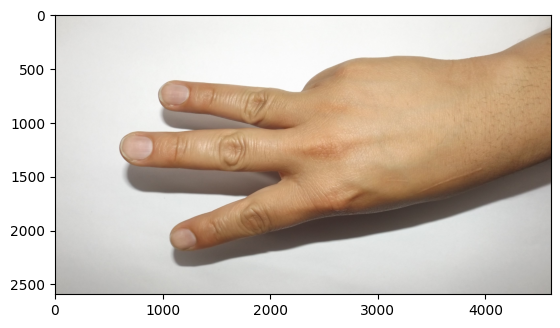

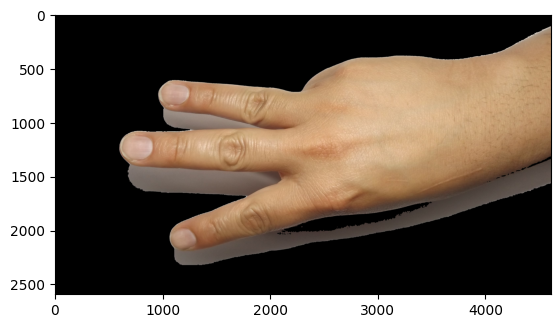

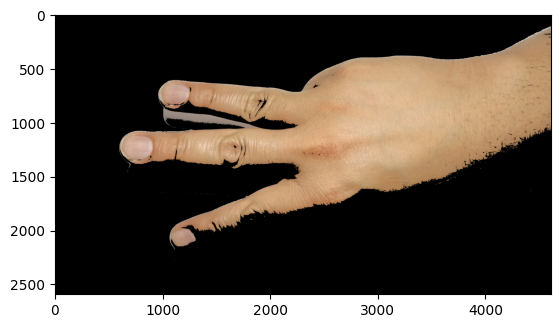

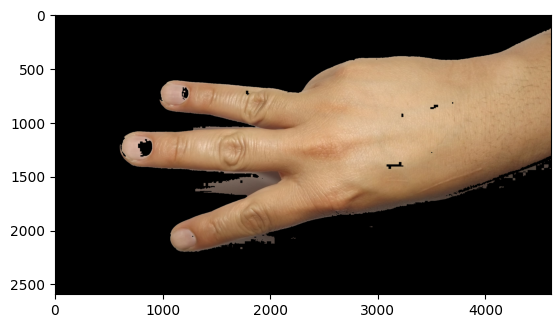

In [7]:
show_cv2_image_bgr(img)
show_cv2_image_bgr(hand)
show_cv2_image_bgr(k_hand)
show_cv2_image_bgr(g_hand)